# American Sign Language (ASL) Classifier   
### Spencer Ball, November 2020

In [7]:
# Importing useful things

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchsummary import summary

import matplotlib.pyplot as plt
from time import time
import numpy as np
from sklearn.metrics import confusion_matrix

In [17]:
# Set hyperparameters

epoch_num = 20             # number of epochs
conv_num = 4               # number of convolutional layers (ONLY WORKS FOR 1,2 or 4)
kern_num = 30              # number of kernels per convolutional layer
fc_size = 32               # neurons in each fully connected layer (excluding the output layer)
lr = 0.1                   # learning rate
batch_size = 32            # batch size

# fixed during 'Hyperparameter Search'
kern_size = 3             # side length of kernels (square kernels)
fc_num = 2                # number of fully connected layers
batch_norm = 0           # 0: do not use batch normalization, 1: use batch norm.
rseed = 1                 # random seed

# loss function choice
loss_func = nn.CrossEntropyLoss()   
loss_func_toggle = 1          # if loss_func = nn.MSELoss, loss_func_toggle == 0 
                              # if loss_func = nn.CrossEntropyLoss, loss_func_toggle == 1 

# choice of optimizer and loss function set immediately before training loop begins (last cell)

In [9]:
# =============== Importing images ====================

dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/Colab Notebooks/ECE324/a4/training_v2')
mydataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/Colab Notebooks/ECE324/a4/myimages',transform=transforms.ToTensor())

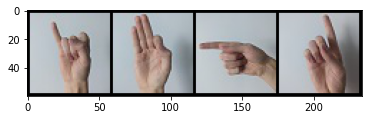

    I           F           G           D


In [10]:
# =============== Printing out a batch of my images with labels  ====================

dataloader_test = torch.utils.data.DataLoader(mydataset, batch_size=4, shuffle=True)   # used only for the test print in this cell

classes = ('A', 'B', 'C', 'D', 'E',
           'F', 'G', 'H', 'I', 'K')   # so integer labels can be converted into their string equivalent

# functions to show an image

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(dataloader_test)
images_test, labels_test = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images_test))
# print labels
print('       '.join('%5s' % classes[labels_test[j]] for j in range(4)))


In [11]:
# ================= Convolutional Neural Network Class =====================

class CNN(nn.Module):

    def __init__(self):
      
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,kern_num,kern_size)
        self.pool1 = nn.MaxPool2d(2,2)
        self.out_size = 56
        self.out_size = int((self.out_size - kern_size + 1)/2)
        if (batch_norm == 1):
            self.conv1_BN = nn.BatchNorm2d(kern_num)

        if (conv_num == 2):
            self.conv2 = nn.Conv2d(kern_num,kern_num,kern_size)        
            self.pool2 = nn.MaxPool2d(2,2)
            self.out_size = int((self.out_size - kern_size + 1)/2)
            if (batch_norm == 1):
                self.conv2_BN = nn.BatchNorm2d(kern_num) 

        if (conv_num == 4):
            self.conv2 = nn.Conv2d(kern_num,kern_num,kern_size)
            self.pool2 = nn.MaxPool2d(2,2)
            self.conv3 = nn.Conv2d(kern_num,kern_num,kern_size)
            self.pool3 = nn.MaxPool2d(2,2)
            self.conv4 = nn.Conv2d(kern_num,kern_num,kern_size)
            self.pool4 = nn.MaxPool2d(2,2)
            for i in range(conv_num-1):
                self.out_size = int((self.out_size - kern_size + 1)/2)
            if (batch_norm == 1):
                self.conv2_BN = nn.BatchNorm2d(kern_num)
                self.conv3_BN = nn.BatchNorm2d(kern_num)
                self.conv4_BN = nn.BatchNorm2d(kern_num)

        if (conv_num != 1) and (conv_num != 2) and (conv_num != 4):
            print('ERROR: # of convolutional layers must be 1 or 2 or 4.')
            
        self.fc1 = nn.Linear(kern_num*self.out_size*self.out_size,fc_size)    
        self.fc2 = nn.Linear(fc_size,10)
        if (batch_norm == 1):
            self.fc1_BN = nn.BatchNorm1d(fc_size)
            self.fc2_BN = nn.BatchNorm1d(10)

    def forward(self,x):

        if (batch_norm == 0):
            x = self.pool1(F.relu(self.conv1(x)))
        if (batch_norm == 1):
            x = self.pool1(F.relu(self.conv1_BN(self.conv1(x))))

        if (conv_num == 2) and (batch_norm == 0):
            x = self.pool2(F.relu(self.conv2(x)))
        if (conv_num == 2) and (batch_norm == 1):
            x = self.pool2(F.relu(self.conv2_BN(self.conv2(x))))

        if (conv_num == 4) and (batch_norm == 0):
            x = self.pool2(F.relu(self.conv2(x)))
            x = self.pool3(F.relu(self.conv3(x)))
            x = self.pool4(F.relu(self.conv4(x)))  
        if (conv_num == 4) and (batch_norm == 1):
            x = self.pool2(F.relu(self.conv2_BN(self.conv2(x))))
            x = self.pool3(F.relu(self.conv3_BN(self.conv3(x))))
            x = self.pool4(F.relu(self.conv4_BN(self.conv4(x))))

        x = x.view(-1,self.out_size*self.out_size*kern_num)  

        if (batch_norm == 0):                
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
        if (batch_norm == 1):
            x = F.relu(self.fc1_BN(self.fc1(x)))
            x = self.fc2_BN(self.fc2(x))

        return x

In [12]:
# =============== Functions used in training ====================

def accuracy(outputs, labels):
    
    correct = 0
    for i in range(len(outputs)):
        max = 0
        max_index = 0
        for j in range(10):      #range(len(outputs[i]))
            if (outputs[i][j] > max):
                max = outputs[i][j]
                max_index = j
        if (labels[i][max_index] == 1):
            correct = correct + 1 
    
    return (correct/len(labels))


def evaluate(model, testloader):
    
    mini_conf_matrix = [[0]*10]*10
    classes_conf = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    running_loss = 0.0
    miniTestAcc = []

    for i, data in enumerate(testloader, 0):
        inputs,labels_real = data
        labels_1H = F.one_hot(labels_real,num_classes=10)
        outputs = model(inputs.float())

        if (loss_func_toggle == 0): # == 0 --> MSELoss
            loss = loss_func(outputs.squeeze(), target=labels_1H.float()) 

        if (loss_func_toggle == 1): # == 1 --> CrossEntropyLoss
            loss = loss_func(outputs, target=labels_real)
        
        running_loss += loss.item()
        miniTestAcc.append(accuracy(outputs,labels_1H))

        labels_guess = torch.max(outputs, 1)[1].numpy()
        mini_conf_matrix += confusion_matrix(labels_real, labels_guess, labels=classes_conf)

    mini_test_loss = running_loss/len(miniTestAcc)
    mini_test_acc = sum(miniTestAcc) / len(miniTestAcc)

    return mini_test_acc,mini_test_loss,mini_conf_matrix


def image_stats(dataset):

    chan0_t, chan1_t, chan2_t = [], [], []

    #print("Collecting Training Data")
    for i in range(len(dataset)):
      
        if i % 100 == 0:
            print(f"Collected {i} samples.")

        image, _ = dataset[i]
        image = np.array(image)
        image = np.divide(image,255)
        chan0_t.append(image[0])
        chan1_t.append(image[1])
        chan2_t.append(image[2])

    mean_t = [np.average(chan0_t), np.average(chan1_t), np.average(chan2_t)]
    print("Mean: ", mean_t)

    std_t = [np.std(chan0_t), np.std(chan1_t), np.std(chan2_t)]
    print("Training Standard Deviation: ", std_t)

    return mean_t, std_t

In [13]:
# ============== Data Normalization & Splitting =========================

# splitting the unnormalized dataset
train_set_dummy, test_set_dummy = random_split(dataset, [int(0.8*len(dataset)), int(0.2*len(dataset))], generator=torch.Generator().manual_seed(0))

# getting mean and standard deviation of training set
mean_t,std_t = image_stats(train_set_dummy)

# transforming dataset
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean_t,std_t)
])

dataset_norm = torchvision.datasets.ImageFolder('/content/drive/My Drive/Colab Notebooks/ECE324/a4/training_v2',transform=transform)

# splitting the normalized dataset
train_set, test_set = random_split(dataset_norm, [int(0.8*len(dataset_norm)), int(0.2*len(dataset_norm))], generator=torch.Generator().manual_seed(0))

# assigning split data to respective data loaders
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

Collected 0 samples.
Collected 100 samples.
Collected 200 samples.
Collected 300 samples.
Collected 400 samples.
Collected 500 samples.
Collected 600 samples.
Collected 700 samples.
Collected 800 samples.
Collected 900 samples.
Collected 1000 samples.
Collected 1100 samples.
Collected 1200 samples.
Collected 1300 samples.
Collected 1400 samples.
Collected 1500 samples.
Collected 1600 samples.
Collected 1700 samples.
Collected 1800 samples.
Collected 1900 samples.
Collected 2000 samples.
Collected 2100 samples.
Collected 2200 samples.
Collected 2300 samples.
Collected 2400 samples.
Collected 2500 samples.
Collected 2600 samples.
Collected 2700 samples.
Collected 2800 samples.
Collected 2900 samples.
Collected 3000 samples.
Mean:  [0.7333647755738381, 0.7331800839601896, 0.7322944927206357]
Training Standard Deviation:  [0.13436176420367302, 0.13380794795181472, 0.1338751241159867]


out_size =  1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
         MaxPool2d-2           [-1, 30, 27, 27]               0
            Conv2d-3           [-1, 30, 25, 25]           8,130
         MaxPool2d-4           [-1, 30, 12, 12]               0
            Conv2d-5           [-1, 30, 10, 10]           8,130
         MaxPool2d-6             [-1, 30, 5, 5]               0
            Conv2d-7             [-1, 30, 3, 3]           8,130
         MaxPool2d-8             [-1, 30, 1, 1]               0
            Linear-9                   [-1, 32]             992
           Linear-10                   [-1, 10]             330
Total params: 26,552
Trainable params: 26,552
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 1.04
Params size (MB): 0.10

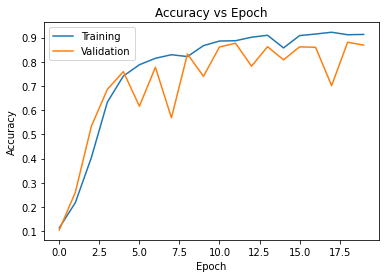

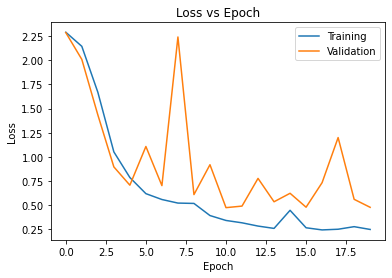

In [18]:
# =============== Training & Plotting ====================

# setting random seed
torch.manual_seed(rseed)

# instantiate model
model = CNN()

# summarize model
print("out_size = ",model.out_size)
print(summary(model, input_size=(3, 56, 56)))

# instantiate optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

# places to store values for plotting   
nRec = 0
trainAccRec = []
testAccRec = [] 
mini_train_acc = []
trainLossRec = []
testLossRec = []
t = []
tic = time()

# frame for confusion matrix

conf_matrix = [[0]*10]*10

# Training Loop

for epoch in range(epoch_num):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # make a 1-Hot Encoded version of the labels (nn.MSELoss uses this)
        labels_1H = F.one_hot(labels,num_classes=10)       

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())

        if (loss_func_toggle == 0): # == 0 --> MSELoss
            loss = loss_func(outputs.squeeze(), target=labels_1H.float()) 

        if (loss_func_toggle == 1): # == 1 --> CrossEntropyLoss
            loss = loss_func(outputs, target=labels)
        
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        mini_train_acc.append(accuracy(outputs,labels_1H))


    mini_test_acc, mini_test_loss, mini_conf_matrix = evaluate(model,testloader)
    testAccRec.append(mini_test_acc)
    testLossRec.append(mini_test_loss)
    epochTrainAcc = sum(mini_train_acc) / len(mini_train_acc)
    trainAccRec.append(epochTrainAcc)
    trainLossRec.append(running_loss/len(mini_train_acc))
    t.append(time()-tic)
    conf_matrix += mini_conf_matrix

    print("\n")  
    print("Epoch:",epoch+1)
    print("Training accuracy:",trainAccRec[epoch])
    print("Validation accuracy:",testAccRec[epoch])
    print("Training Loss:",trainLossRec[epoch])
    print("Validation Loss:",testLossRec[epoch])

    mini_train_acc = []
    running_loss = 0.0

toc = time()       
print('Finished Training')


# Plotting for the boys

domain = np.arange(epoch_num)

fig, accPlt = plt.subplots()                                 # Create a figure and an axes.\n",
accPlt.plot(domain, trainAccRec, label='Training')           # Plot some data on the axes.\n",
accPlt.plot(domain, testAccRec, label='Validation')         # Plot more data on the axes...\n",
accPlt.set_xlabel('Epoch')                               # Add an x-label to the axes.\n",
accPlt.set_ylabel('Accuracy')                                # Add a y-label to the axes.\n",
accPlt.set_title("Accuracy vs Epoch")                    # Add a title to the axes.\n",
accPlt.legend() 

fig, lossPlt = plt.subplots()                                 # Create a figure and an axes.\n",
lossPlt.plot(domain, trainLossRec, label='Training')           # Plot some data on the axes.\n",
lossPlt.plot(domain, testLossRec, label='Validation')         # Plot more data on the axes...\n",
lossPlt.set_xlabel('Epoch')                               # Add an x-label to the axes.\n",
lossPlt.set_ylabel('Loss')                                # Add a y-label to the axes.\n",
lossPlt.set_title("Loss vs Epoch")                    # Add a title to the axes.\n",
lossPlt.legend() 

print('Total training time =',toc-tic)

# getting highest validation accuracy
maxAcc = 0
for val in testAccRec:
    if (val > maxAcc):
        maxAcc = val
print('Highest Validation Accuracy:',maxAcc)

print('FINAL CONFUSION MATRIX:',conf_matrix)


    